In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras
import preprocessing as pre

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

from graficos_modelos import graficar_auc_roc, graficar_matriz_confusion, graficar_curva_aprendizaje
from funciones_auxiliares import traer_datasets, traer_dataset_prediccion_final, separar_dataset, mapear_target_binario, mapear_target_binario_a_categorico

# Redes neuronales

Definimos el método que generará la red neuronal con una arquitectura constante, la cual tendra dos capas ocultas de 10 y 8 neuronas respectivamente. A su vez, se utilizara la funcion de activación de tangente hiperbólica en las capas ocultas, y una sigmoidea en la capa de output ya que se trata de un problema de clasificación binaria. Por el mismo motivo, la funcion de perdida a optimizar será la cross-entropy.

El método de regularización a utilizar sera dropout con parametro 0.25 para mantener el modelo lo más simple posible y no sobrecargarlo con computo.

In [2]:
def crear_red(optimizer):
    red_neuronal = Sequential()
    red_neuronal.add(Dense(8, input_dim=18, activation='tanh', kernel_regularizer=l2(0.001)))
    red_neuronal.add(Dropout(0.25))
    red_neuronal.add(Dense(5, activation='tanh', kernel_regularizer=l2(0.001)))
    red_neuronal.add(Dropout(0.25))
    red_neuronal.add(Dense(1, activation='sigmoid'))
    red_neuronal.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=keras.metrics.AUC(name="auc"))
    return red_neuronal

Dada la alta complejidad temporal de las redes neuronales, nos vemos obligados a tratarla de una manera distinta al resto de modelos. 
Esta será tal que, mateniendo una misma arquitectura, probaremos dos combinaciones distintas de hiperparametros para un mismo preprocesamiento, y la que mejor performance tenga sobre holdout, será probada con el segundo preprocesamiento. Finalmente, se comaprará la misma red con los mismos hiperpametros pero que entrenada con datos preprocesados de distinta manera, y la que mejor métricas produzca, será utilizada para la predicción final y para compararse con las otras familias de modelos

### Obtención de datos 

In [3]:
df, df_sin_target, solo_target = traer_datasets()

X_train, X_test, y_train, y_test = separar_dataset(df_sin_target, solo_target)

X_train.is_copy=False
X_test.is_copy=False
y_train.is_copy=False
y_test.is_copy=False

y_train.set_index('id', inplace=True)
y_train = y_train.sort_values(by=['id'], ascending=True).copy()

y_test.set_index('id', inplace=True)
y_test = y_test.sort_values(by=['id'], ascending=True).copy()

### Definiendo distintos preprocesamientos

In [4]:
def preprocesamiento_1(df_original:pd.DataFrame, imputer=None, scaler=None):
    df = df_original.copy(deep=True)
    df = pre.limpiar_datos(df)
    df = pre.aplicar_dummy_variables_encoding(df, ['llovieron_hamburguesas_hoy'])
    pre.eliminar_features(df, ['dia','barrio', 'direccion_viento_tarde', 'direccion_viento_temprano', 'rafaga_viento_max_direccion'])

    if(imputer is None):
        imputer = pre.entrenar_iterative_imputer(df)
    df = pre.imputar_missings_iterative(df, imputer)
    
    if(scaler is None):
        scaler = pre.entrenar_normalizador_minmax(df)
    df = pre.normalizar_dataframe(df, scaler)
    
    return df, imputer, scaler

Primer preprocesamiento: La idea de este preprocesamiento es que sea mas simple que el segundo, para poder comprar distintos niveles de complejidad y sofisticación a la hora de preprocesar datos. En este caso, se limpian los datos transformando la feature de presión atmosférica tarde a float, ya que originalmente tiene valores invalidos con tipo de dato string y además se pasan los nulos a nan de numpy. También se eliminan todas menos las features categóricas  menos "llovieron_hamburguesas_hoy" ya que por lo visto en la parte 1 esta es la única que proporciona información relevante respecto al target. Finalmente, para el caso de que no se reciba un imputer, creara y entrenará un iterative imputer, y ya sea reciendolo como parametro o generadolo, se usará dicho imputer para rellenar los missings. Lo mismo sucede con la normalización de los datos, ya que si no se recibe ningun normalizador, se entrenara un normalizador min max con parametros por defecto (rango 0 a 1) y se normalizaran los datos. Creemos que este normalizador es más génerico que el standard el cual usa valores del propio dataset para normalizar, y por ende menos sofisticado.

In [5]:
def preprocesamiento_2(df_original:pd.DataFrame, imputer=None, scaler=None):    
    df = df_original.copy(deep=True)
    df = pre.limpiar_datos(df)
    pre.eliminar_features(df, ['dia','barrio'])
    df = pre.aplicar_dummy_variables_encoding(df, ['llovieron_hamburguesas_hoy'])
    df = pre.aplicar_hashing_trick(df, ['direccion_viento_tarde','direccion_viento_temprano','rafaga_viento_max_direccion'], [3,3,3])

    if(imputer is None):
        imputer = pre.entrenar_iterative_imputer(df)
    df = pre.imputar_missings_iterative(df, imputer)
    
    if(scaler is None):
        scaler = pre.entrenar_normalizador_standard(df)
    df = pre.normalizar_dataframe(df, scaler)
    df = pre.reduccion_PCA(df, 16)

    return df, imputer, scaler

Segundo preprocesamiento: Tiene como objetivo ser bastante sofisticado y complejo. Esto se puede observar ya que además de limpiar los datos al igual que el primer preprocesamiento, unicamente se descartan las features dia y barrio (también por el análisis de la parte 1), y las otras categóricas se transforman tanto con dummy encoding cuando la dimensionalidad de valores posibles es baja (solo para llovieron_hamburguesas_hoy) como con hashing trick a vectores de tres dimensiones para una dimensionalidad de valores mas alta (direcciones de vientos). Utiliza nuevamente el iterative imputer, pero en lugar de usar el normalizador min max, utiliza el normalizador standard el cual como se menciono con anterioridad, esta creado sobre valores del mismo dataset. Finalmente, dado que se aumento bastante la dimensionalidad del dataset con los metodos de transformación de features categóricas, se aplicara una reducción PCA a 16 dimensiones, el cual implica que estamos reduciendo la dimensión del dataset a una dimensión mucho más pequeña para que el input de la red sea el mismo en ambos casos. Esta reducción podría generar perdida de información la cual se vería reflejada en la performance del modelo.

### Aplicamos preprocesamientos 1 y 2 para obtener X_train_1 / X_test_1 y X_train_2 / X_test_2 respectivamente

In [6]:
X_train_1, imputer_entrenado_1, scaler_entrenado_1  = preprocesamiento_1(X_train)
X_test_1, imputer_entrenado_1, scaler_entrenado_1 = preprocesamiento_1(X_test, imputer_entrenado_1, scaler_entrenado_1)

In [7]:
X_train_2, imputer_entrenado_2, scaler_entrenado_2  = preprocesamiento_2(X_train)
X_test_2, imputer_entrenado_2, scaler_entrenado_2 = preprocesamiento_2(X_test, imputer_entrenado_2, scaler_entrenado_2)

### Búsqueda de Hiperparámetros para el modelo que entrenará sobre X_train_1

Los hiperparametros a definir en una red neuronal son:
- loss: Función de perdida a optimizar. En nuestro caso, por ser clasificación binaria, debe ser o softmax o binary cross-entropy. Elegimos la última por simpleza.
- optimizer: El optimizador que se utilizará para encontrar los mejores parametros (pesos y biases) de la red. 
    - learning_rate: Es un hiperparametro del optimizador que indica cuan grande sera el "aprendizaje" en cada epoca. Si es pequeño, tomara mas epocas el entrenamiento pero tendrá menos riesgo de diverger en los parametros como lo haría un learning rate alto
- metrics: Métricas que se utilizaran para mostrar y validar (en caso de usar callbacks) el resultado del entrenamiento
- epochs: Cantidad de iteraciones que realizara la red para ajustar sus pesos y biases

Planteamos como posibles hiperpametros dos optimizadores, Adam que resulta un optimizador de complejidad media, y Adagrad que es un optimizador de complejidad mas elevada. 

Como el problema a resolver no es extremadamente complejo, no hay necesidad de complejizar tanto el computo de la red con optimizadores mas elaborados para obtener una buena performance.

Los learning rates propuestos se consideran relativamente valores bajos para que el aprendizaje sea suave y no abrupto/errático

In [8]:
mapeo_binario_v = np.vectorize(mapear_target_binario)

In [9]:
y_train_np = y_train['llovieron_hamburguesas_al_dia_siguiente'].to_numpy()
y_train_binario = mapeo_binario_v(y_train_np)

y_test_np = y_test['llovieron_hamburguesas_al_dia_siguiente'].to_numpy()
y_test_binario = mapeo_binario_v(y_test_np)

Creamos entonces la red con el optimizador adam, el cual esta en el medio en la escala de complejidad y performance, y entrenamos un numero arbitrario de epochs halladas. Además agregamos criterio de early stopping para no sobreentrenar la red y que overfitee.

In [10]:
red_n = crear_red(keras.optimizers.Adam(learning_rate=0.0001))
red_n.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 152       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 203
Trainable params: 203
Non-trainable params: 0
_________________________________________________________________


In [11]:
early_stopping = EarlyStopping(monitor='val_auc', patience=50, mode='max')

In [12]:
historia = red_n.fit(
    X_train_1, y_train_binario, epochs=200, 
    validation_data=(X_test_1, y_test_binario), 
    verbose=1,
    callbacks=[early_stopping],
)

Epoch 1/200
3199/3199 [==============================] - 3s 673us/step - loss: 0.5486 - auc: 0.6509 - val_loss: 0.4544 - val_auc: 0.8196
Epoch 2/200
3199/3199 [==============================] - 2s 624us/step - loss: 0.4600 - auc: 0.7780 - val_loss: 0.4196 - val_auc: 0.8335
Epoch 3/200
3199/3199 [==============================] - 2s 631us/step - loss: 0.4339 - auc: 0.8079 - val_loss: 0.4046 - val_auc: 0.8431
Epoch 4/200
3199/3199 [==============================] - 2s 666us/step - loss: 0.4204 - auc: 0.8217 - val_loss: 0.3963 - val_auc: 0.8500
Epoch 5/200
3199/3199 [==============================] - 2s 639us/step - loss: 0.4142 - auc: 0.8282 - val_loss: 0.3904 - val_auc: 0.8543
Epoch 6/200
3199/3199 [==============================] - 2s 610us/step - loss: 0.4076 - auc: 0.8340 - val_loss: 0.3864 - val_auc: 0.8572
Epoch 7/200
3199/3199 [==============================] - 2s 689us/step - loss: 0.4049 - auc: 0.8368 - val_loss: 0.3835 - val_auc: 0.8590
Epoch 8/200
3199/3199 [==================

### Curva de aprendizaje


Graficamos la curva de aprendizaje para tener una mejor idea de como fue el entrenamiento de nuestra red

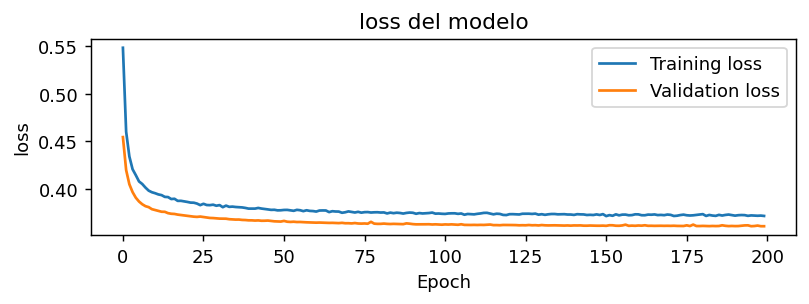

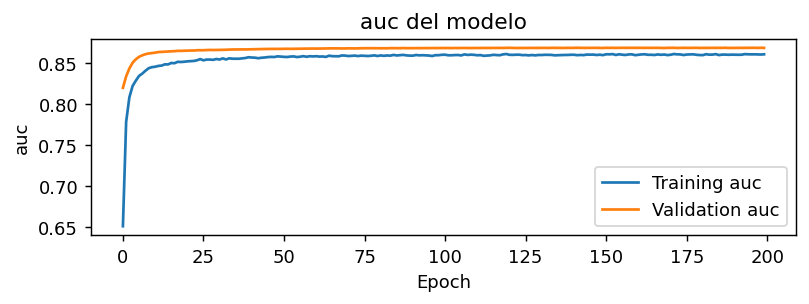

In [13]:
graficar_curva_aprendizaje(historia,'loss')
graficar_curva_aprendizaje(historia,'auc')

### Predicción del modelo sobre holdout

Una vez que vimos que no se produjo un overfitting (dado que las curvas de validation y training son muy similares) y que la métrica alcanzada es lo suficientemente buena, realizamos la predicción sobre los valores de holdout, y gráficamos la curva AUC-ROC y la matriz de confusión

In [14]:
y_pred = red_n.predict(X_test_1)

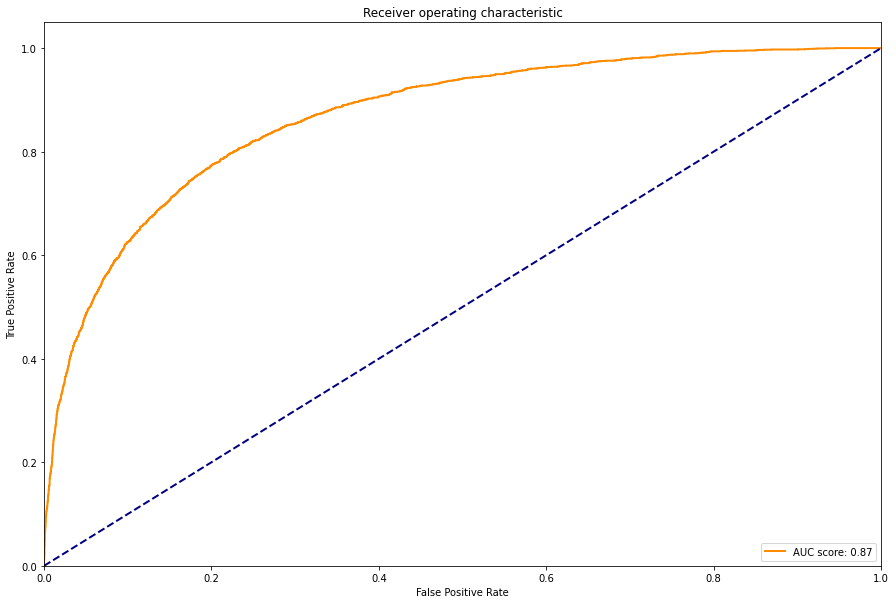

AUC-ROC para este modelo es: 0.8681712856841466


In [15]:
graficar_auc_roc(y_test_binario, y_pred) 

c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


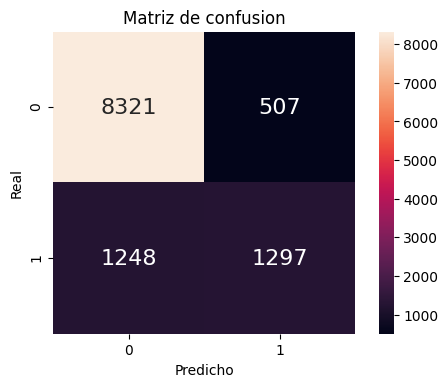

In [16]:
graficar_matriz_confusion(y_test_binario, y_pred.round())

In [17]:
print(classification_report(y_test_binario, y_pred.round(), target_names=['no', 'si']))

              precision    recall  f1-score   support

          no       0.87      0.94      0.90      8828
          si       0.72      0.51      0.60      2545

    accuracy                           0.85     11373
   macro avg       0.79      0.73      0.75     11373
weighted avg       0.84      0.85      0.84     11373



Aunque a partir de la red obtuvimos una métrica bastante buena, intentaremos mejorarla con un optimizador mas sofisticado que adam, como lo es adagrad, y ampliando la cantidad de epochs a 500.

In [18]:
red_sofisticada = crear_red(keras.optimizers.Adagrad(learning_rate=0.0001))
red_sofisticada.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 152       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 45        
_________________________________________________________________
dropout_3 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 203
Trainable params: 203
Non-trainable params: 0
_________________________________________________________________


In [19]:
historia_sofisticada = red_sofisticada.fit(
    X_train_1, y_train_binario, epochs=500, 
    validation_data=(X_test_1, y_test_binario), 
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/500
3199/3199 [==============================] - 3s 708us/step - loss: 0.7731 - auc: 0.4125 - val_loss: 0.7254 - val_auc: 0.2619
Epoch 2/500
3199/3199 [==============================] - 2s 648us/step - loss: 0.7361 - auc: 0.4163 - val_loss: 0.7000 - val_auc: 0.2605
Epoch 3/500
3199/3199 [==============================] - 2s 610us/step - loss: 0.7170 - auc: 0.4187 - val_loss: 0.6830 - val_auc: 0.2595
Epoch 4/500
3199/3199 [==============================] - 2s 606us/step - loss: 0.7016 - auc: 0.4233 - val_loss: 0.6703 - val_auc: 0.2594
Epoch 5/500
3199/3199 [==============================] - 2s 621us/step - loss: 0.6901 - auc: 0.4255 - val_loss: 0.6600 - val_auc: 0.2594
Epoch 6/500
3199/3199 [==============================] - 2s 609us/step - loss: 0.6817 - auc: 0.4259 - val_loss: 0.6515 - val_auc: 0.2598
Epoch 7/500
3199/3199 [==============================] - 2s 603us/step - loss: 0.6743 - auc: 0.4277 - val_loss: 0.6442 - val_auc: 0.2602
Epoch 8/500
3199/3199 [==================

KeyboardInterrupt: 

In [ ]:
graficar_curva_aprendizaje(historia_sofisticada,'loss')
graficar_curva_aprendizaje(historia_sofisticada,'auc')

In [ ]:
y_pred_sofisticado = red_sofisticada.predict(X_test)

In [ ]:
graficar_auc_roc(y_test_binario, y_pred_sofisticado) 

In [ ]:
graficar_matriz_confusion(y_test_binario, y_pred_sofisticado.round())

In [ ]:
print(classification_report(y_test_binario, y_pred_sofisticado.round(), target_names=['no', 'si']))

Vemos que nuestro intento de mejorar la performance resulto completamente contraproducente, habiendo generado un modelo el cual tiene una metrica AUC ROC muy baja. Esto puede deberse a que si bien el optimizador adagrad es mas complejo y en general mas sofisticado, no funciona tan bien para la arquitectura y el set de datos y la prediccion de lluvia de hamburguesas.

Además se observa que el modelo no logra mejorar la métrica auc para el set de validación y para training es muy errática, a pesar de tener un learning rate bastante bajo. 

Como las métricas de loss tanto para el set de validación como para el de entramiento dan una curva bastante similar pero trasladada hacia arriba, no podemos afirmar que el problema se deba a overfit.

Por esto, no será tenido en cuenta en la conclusión

# Modelo con preprocesamiento normalizados

Intentaremos mejorar la performance agregando el preprocesamiento de normalizacion de los datos ya que en general suele ayudar a los modelos.

In [ ]:
red_norm = crear_red(keras.optimizers.Adam(learning_rate=0.0001))

historia_norm = red_norm.fit(
    X_train_2, y_train_binario, epochs=200, 
    validation_data=(X_test_2, y_test_binario), 
    verbose=1,
    callbacks=[early_stopping]
)

In [ ]:
graficar_curva_aprendizaje(historia_norm,'loss')
graficar_curva_aprendizaje(historia_norm,'auc')

In [ ]:
y_pred_norm = red_norm.predict(X_test_2)

In [ ]:
graficar_auc_roc(y_test_binario, y_pred_norm) 

In [ ]:
graficar_matriz_confusion(y_test_binario, y_pred_norm.round()) 

In [ ]:
print(classification_report(y_test_binario, y_pred_norm.round(), target_names=['no', 'si']))

# Conclusiones y predicción final

Vemos que el modelo que mejor funciona según la metrica AUC de keras es el que utiliza a adam como optimizador y 200 epochs. Sin embargo el criterio de early stopping con una paciencia relativamente baja (50) nos indica que aproximadamente a partir de la epoch 20 (dado que el entrenamiento se frena en la epoca 70) ya no tiene sentido seguir entrenando. Por lo tanto la complejidad computacional que puede generar la normalizacion de los datos, podría verse compensada por lo que se ahorra al entrenar la red. 

Sin embargo vemos en la matriz de confusión que este modelo pierde instancias de True positives acertadas, y mejora los true negatives absolutos. Esto podría verse como una desventaja frente al primer modelo ya que a grandes rasgos, lo dificil del problema propuesto por Flint es predecir los true positives. 

A pesar de que el primer modelo resulte en mayores true positives acertados, también aumenta la proporción de false positives, resultando en una métrica de precision menor, y en una métrica de recall mas alta.

Concluimos entonces que por tener metricas auc-roc, accuracy y precision mas altas, el mejor modelo para predecir será el ultimo, que utiliza el preprocesamiento normalizado. 

Procedemos a realizar la prediccion del dataset nuevo con este modelo y guardarlo en el archivo csv

In [ ]:
def formatear_prediccion_red(predicciones):
    pred_finales = []
    for pred in predicciones:
        pred_finales.append(pred[0])
    return pred_finales 

In [ ]:
from funciones_auxiliares import exportar_prediccion_final

df_prediccion_final = traer_dataset_prediccion_final()
ids = df_prediccion_final['id'].to_numpy()

df_prediccion_final = preprocesamiento_basico([df_prediccion_final])[0]
df_prediccion_final = normalizar_datos([df_prediccion_final])

predicciones = red_norm.predict(df_prediccion_final).round()
mapeo_categorico_v = np.vectorize(mapear_target_binario_a_categorico)
predicciones = mapeo_categorico_v(predicciones)
predicciones = formatear_prediccion_red(predicciones)

exportar_prediccion_final(ids, predicciones, 'red_neuronal')